<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-이상치-처리" data-toc-modified-id="1.-이상치-처리-1">1. 이상치 처리</a></span></li><li><span><a href="#2.-타깃-값-로그-변환" data-toc-modified-id="2.-타깃-값-로그-변환-2">2. 타깃 값 로그 변환</a></span></li><li><span><a href="#3.-범주형-&amp;-연속형-변수-처리" data-toc-modified-id="3.-범주형-&amp;-연속형-변수-처리-3">3. 범주형 &amp; 연속형 변수 처리</a></span></li><li><span><a href="#4.-Extra-Trees-Regressor-모델-학습" data-toc-modified-id="4.-Extra-Trees-Regressor-모델-학습-4">4. Extra Trees Regressor 모델 학습</a></span></li><li><span><a href="#5.-예측-모델-저장" data-toc-modified-id="5.-예측-모델-저장-5">5. 예측 모델 저장</a></span></li><li><span><a href="#6.-예측-템플릿-생성-및-모델-적용" data-toc-modified-id="6.-예측-템플릿-생성-및-모델-적용-6">6. 예측 템플릿 생성 및 모델 적용</a></span></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
import seaborn as sns
%matplotlib inline
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('./data/total_data.csv')
print(data.shape)
data.head(3)

(2056899, 17)


,계절,월,일,요일,공휴일,성별,연령대,대분류명,소분류명,평균일강수량(mm),평균풍속(km/h),평균습도(%rh),일조합,체감온도(℃),일 미세먼지 농도(㎍/㎥),10만건당 건수,구매건수
0,겨울,1,1,0,1.0,F,20,식품,가공란,0.0,6.84,51.0,8.7,-2.810026,32.962963,0.480964,37
1,겨울,1,1,0,1.0,F,30,식품,가공란,0.0,6.84,51.0,8.7,-2.810026,32.962963,0.480964,16
2,겨울,1,1,0,1.0,F,40,식품,가공란,0.0,6.84,51.0,8.7,-2.810026,32.962963,0.480964,9


In [3]:
beauty = data[data['대분류명']=='뷰티']
beauty.drop(['대분류명','평균습도(%rh)','일조합','구매건수'], axis=1, inplace=True)
beauty.dropna(inplace=True)
beauty.reset_index(drop=True, inplace=True)
print(beauty.shape)
beauty.head(3)

(695969, 13)


,계절,월,일,요일,공휴일,성별,연령대,소분류명,평균일강수량(mm),평균풍속(km/h),체감온도(℃),일 미세먼지 농도(㎍/㎥),10만건당 건수
0,겨울,1,1,0,1.0,F,20,기능성 링클케어 화장품,0.0,6.84,-2.810026,32.962963,12.154295
1,겨울,1,1,0,1.0,F,40,기능성 링클케어 화장품,0.0,6.84,-2.810026,32.962963,12.154295
2,겨울,1,1,0,1.0,F,20,기능성 모공관리 화장품,0.0,6.84,-2.810026,32.962963,36.000828


대분류명, 평균습도(다중공선성 문제), 일조합(추후 데이터 수집 문제), 구매건수 변수 제외 및 결측치 제거

In [4]:
봄 = beauty[beauty['계절']=='봄'].reset_index(drop=True).drop('계절', axis=1)
여름 = beauty[beauty['계절']=='여름'].reset_index(drop=True).drop('계절', axis=1)
가을 = beauty[beauty['계절']=='가을'].reset_index(drop=True).drop('계절', axis=1)
겨울 = beauty[beauty['계절']=='겨울'].reset_index(drop=True).drop('계절', axis=1)

# 1. 이상치 처리

In [60]:
# 봄 데이터 이상치 확인
def outliers(data):
    q1, q3 = np.percentile(data, [25,75])
    iqr = q3 - q1
    upper_bound = q3 + (iqr * 1.5)
    lower_bound = q1 - (iqr * 1.5)
    return np.where((data > upper_bound) | (data < lower_bound))

In [61]:
강수량_idx = outliers(봄['평균일강수량(mm)'])[0]
미세먼지_idx = outliers(봄['일 미세먼지 농도(㎍/㎥)'])[0]
풍속_idx = outliers(봄['평균풍속(km/h)'])[0]

# 이상치 평균으로 처리
강수량_mean = 봄['평균일강수량(mm)'].mean()
봄.loc[강수량_idx, '평균일강수량(mm)'] = 강수량_mean

미세먼지_mean = 봄['일 미세먼지 농도(㎍/㎥)'].mean()
봄.loc[미세먼지_idx, '일 미세먼지 농도(㎍/㎥)'] = 미세먼지_mean

풍속_mean = 봄['평균풍속(km/h)'].mean()
봄.loc[풍속_idx, '평균풍속(km/h)'] = 풍속_mean

print(봄.shape)
봄.head(3)

(178079, 12)


,월,일,요일,공휴일,성별,연령대,소분류명,평균일강수량(mm),평균풍속(km/h),체감온도(℃),일 미세먼지 농도(㎍/㎥),10만건당 건수
0,3,1,3,1.0,F,20,화장 퍼프,0.9,7.619634,-1.216191,33.592593,21.806179
1,3,1,3,1.0,F,30,화장 퍼프,0.9,7.619634,-1.216191,33.592593,21.806179
2,3,1,3,1.0,F,40,화장 퍼프,0.9,7.619634,-1.216191,33.592593,21.806179


# 2. 타깃 값 로그 변환

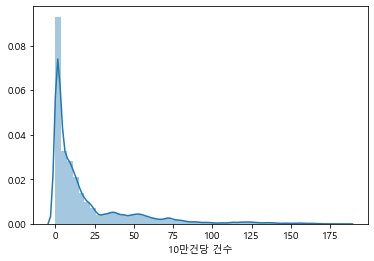

In [62]:
# Target 값 분포 확인 및 로그 변환
sns.distplot(봄['10만건당 건수'])

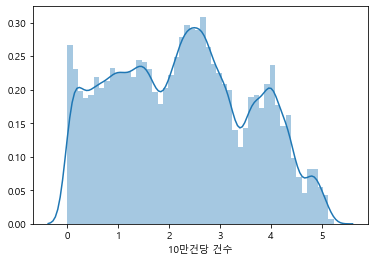

In [63]:
봄['10만건당 건수'] = np.log1p(봄["10만건당 건수"])
sns.distplot(봄['10만건당 건수'])

# 3. 범주형 & 연속형 변수 처리

In [64]:
봄.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178079 entries, 0 to 178078
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   월               178079 non-null  int64  
 1   일               178079 non-null  int64  
 2   요일              178079 non-null  int64  
 3   공휴일             178079 non-null  float64
 4   성별              178079 non-null  object 
 5   연령대             178079 non-null  int64  
 6   소분류명            178079 non-null  object 
 7   평균일강수량(mm)      178079 non-null  float64
 8   평균풍속(km/h)      178079 non-null  float64
 9   체감온도(℃)         178079 non-null  float64
 10  일 미세먼지 농도(㎍/㎥)  178079 non-null  float64
 11  10만건당 건수        178079 non-null  float64
dtypes: float64(6), int64(4), object(2)
memory usage: 16.3+ MB


In [65]:
# 범주형 변수 레이블 인코딩
# 트리 계열 모델은 숫자의 차이에 영향을 받지 않으므로 레이블 인코딩을 사용해도 무방
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le = le.fit(봄['성별'])
봄['성별'] = le.transform(봄['성별'])

le2 = LabelEncoder()
le2 = le2.fit(봄['소분류명'])
봄['소분류명'] = le2.transform(봄['소분류명'])

label_df = 봄[['성별','소분류명']]
label_df.head(3)

,성별,소분류명
0,0,130
1,0,130
2,0,130


In [66]:
# 연속형 변수 스케일링
from sklearn.preprocessing import StandardScaler

nu = 봄.drop(['성별','소분류명','10만건당 건수'], axis=1)

scaler = StandardScaler()
scaler = scaler.fit(nu)
scaled = scaler.transform(nu)
scaled_df = pd.DataFrame(scaled, columns=nu.columns)
scaled_df.head(3)

,월,일,요일,공휴일,연령대,평균일강수량(mm),평균풍속(km/h),체감온도(℃),일 미세먼지 농도(㎍/㎥)
0,-1.222685,-1.671889,0.010821,4.743034,-1.347453,0.08263,0.120131,-2.172891,-0.096452
1,-1.222685,-1.671889,0.010821,4.743034,-0.589920,0.08263,0.120131,-2.172891,-0.096452
2,-1.222685,-1.671889,0.010821,4.743034,0.167613,0.08263,0.120131,-2.172891,-0.096452


In [67]:
X = pd.concat([scaled_df, label_df], axis=1)
y = 봄['10만건당 건수']
print(X.shape)
print(y.shape)

(178079, 11)
(178079,)


# 4. Extra Trees Regressor 모델 학습

In [18]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    shuffle=True, random_state=11)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(142463, 11) (142463,)
(35616, 11) (35616,)


In [27]:
param_grid = {'n_estimators':[100,200],'max_features':[4,8,11],'min_samples_split':[2,4,8]}
grid = GridSearchCV(ExtraTreesRegressor(), param_grid=param_grid,
                    scoring=['neg_mean_squared_error'], refit='neg_mean_squared_error',
                    return_train_score=True, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ExtraTreesRegressor(), n_jobs=-1,
             param_grid={'max_features': [4, 8, 11],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [100, 200]},
             refit='neg_mean_squared_error', return_train_score=True,
             scoring=['neg_mean_squared_error'])

In [28]:
grid.best_params_

{'max_features': 11, 'min_samples_split': 2, 'n_estimators': 200}

In [29]:
grid.best_score_

-0.01155133996469081

사이킷런에서는 score 값이 클수록 좋은 평가 결과로 나타나기 때문에,

회귀 평가 지표의 값이 작을수록 좋은 특성을 반영하기 위해 보정이 필요함

neg_mean_squared_error = -1 * mean_squared_error

In [30]:
print('RMSE : {0:.3f}'.format(np.sqrt(-1 * grid.best_score_)))

RMSE : 0.107


In [31]:
model = grid.best_estimator_
model

ExtraTreesRegressor(max_features=11, n_estimators=200)

# 5. 예측 모델 저장

In [39]:
import pickle
import joblib

In [33]:
joblib.dump(model, './model/ExtraTreesRegressor(봄)') 

['./model/ExtraTreesRegressor(봄)']

# 6. 예측 템플릿 생성 및 모델 적용

In [5]:
from bs4 import BeautifulSoup
import requests

In [49]:
table.loc[4]['강수량(mm)']

'0.6'

In [55]:
import re
try: 
    re.search('^[+-]?\d*(\.?\d*)$', table.loc[4]['강수량(mm)'])
    print('Yes')
except:
    print('No')

Yes


In [44]:
type(table.loc[0]['강수량(mm)'])

float

In [36]:
def weather_i(gender, age):
    req = requests.get('https://www.weatheri.co.kr/forecast/forecast10.php')
    # 한글이 깨지는 문제를 해결하고자 decode 사용
    soup = BeautifulSoup(req.content.decode('utf-8','replace'), 'html.parser')

    # 월, 일, 요일
    date = soup.find('font', color='#124d79').text
    year, month, day = date[:4], date[6:8], date[10:12]
    ymd = year + '-' + month + '-' + day
    ymd = pd.to_datetime(ymd)
    week = ymd.weekday()
    
    # 공휴일
    holiday = pd.read_excel('./data/국가공휴일2.xlsx')
    holi_idx = holiday[(holiday['년'] == int(year)) & (holiday['월'] == int(month)) & (holiday['일'] == int(day))].index
    if len(holi_idx) == 0:
        holi = 0   # 공휴일이면 1, 아니면 0
    else:
        holi = 1
    
    # 강수량, 풍속, 체감온도 (서울)
    table = pd.read_html(str(soup.select('table')[10]))[0]
    table = table.rename(columns=table.iloc[0]).drop(table.index[0])
    table.reset_index(drop=True, inplace=True)
    table['풍 속(m/s)'] = table['풍 속(m/s)'].apply(lambda x: float(x)*3.6)
    table = table.rename(columns={'풍 속(m/s)':'풍 속(km/h)'})

    data = []
    
    if np.isnan(table.loc[0]['강수량(mm)']):
        rain = 0
    else:
        rain = table.loc[0]['강수량(mm)']
    wind = table.loc[0]['풍 속(km/h)']
    temp = float(table.loc[0]['현재기온(℃)'])
    a_temp = 13.12 + 0.6215*temp - 11.37*(wind**0.16) + 0.3965*(wind**0.16)*temp
    
    # 미세먼지
    req2 = requests.get('https://www.weatheri.co.kr/special/special05_1.php?a=1')
    soup2 = BeautifulSoup(req2.content.decode('utf-8','replace'), 'html.parser')
    
    table2 = pd.read_html(str(soup2.select('table')[11]))[1]
    table2 = table2.rename(columns=table2.iloc[0]).drop(table2.index[0])
    table2.reset_index(drop=True, inplace=True)
    
    pm10 = table2.iloc[0,2]
    
    data.append([month, day, week, holi, gender, age, rain, wind, a_temp, pm10])
    df = np.transpose(pd.DataFrame(data[0]))
    df.columns = ['월','일','요일','공휴일','성별','연령대','평균일강수량(mm)','평균풍속(km/h)','체감온도(℃)','일 미세먼지 농도(㎍/㎥)']
    return df

강수량/풍속/체감온도 수집 페이지와 미세먼지 페이지의 **지역 구분이 달라 city 입력 기준을 어떻게 해야 할지 고민**

-> 대표적으로 '서울' 지역만 선정하여 크롤링하기로 함

In [39]:
df = weather_i('F','20')
print(df.shape)
df.head(3)

(1, 10)


,월,일,요일,공휴일,성별,연령대,평균일강수량(mm),평균풍속(km/h),체감온도(℃),일 미세먼지 농도(㎍/㎥)
0,06,23,2,0,F,20,0,9,28.6006,24


In [38]:
for i in range(beauty.소분류명.nunique()-1):
    df = df.append(pd.Series(df[0:1].values[0], index=df.columns), ignore_index=True)
df['소분류명'] = beauty.소분류명.unique()
df = df[['월','일','요일','공휴일','성별','연령대','소분류명','평균일강수량(mm)','평균풍속(km/h)','체감온도(℃)','일 미세먼지 농도(㎍/㎥)']]

print(df.shape)
df.head(3)

(131, 11)


,월,일,요일,공휴일,성별,연령대,소분류명,평균일강수량(mm),평균풍속(km/h),체감온도(℃),일 미세먼지 농도(㎍/㎥)
0,06,23,2,0,F,20,기능성 링클케어 화장품,0,9,28.6006,24
1,06,23,2,0,F,20,기능성 모공관리 화장품,0,9,28.6006,24
2,06,23,2,0,F,20,기능성 아이케어 화장품,0,9,28.6006,24


In [70]:
# 범주형 변수 레이블 인코딩

df['성별'] = le.transform(df['성별'])
df['소분류명'] = le2.transform(df['소분류명'])

label_df2 = df[['성별','소분류명']]
label_df2.head(3)

,성별,소분류명
0,0,0
1,0,1
2,0,2


In [72]:
# 연속형 변수 스케일링
from sklearn.preprocessing import StandardScaler

nu = df.drop(['성별','소분류명'], axis=1)

scaled = scaler.transform(nu)
scaled_df2 = pd.DataFrame(scaled, columns=nu.columns)
scaled_df2.head(3)

,월,일,요일,공휴일,연령대,평균일강수량(mm),평균풍속(km/h),체감온도(℃),일 미세먼지 농도(㎍/㎥)
0,2.434567,0.475567,1.523417,-0.210836,-1.347453,-0.662858,4.162546,2.626073,1.48447
1,2.434567,0.475567,1.523417,-0.210836,-1.347453,-0.662858,4.162546,2.626073,1.48447
2,2.434567,0.475567,1.523417,-0.210836,-1.347453,-0.662858,4.162546,2.626073,1.48447


In [79]:
test = pd.concat([scaled_df2, label_df2], axis=1)
print(test.shape)

(131, 11)


In [80]:
et_model = joblib.load('./model/ExtraTreesRegressor(봄)') 
pred = et_model.predict(test)
pred

array([2.45353389, 4.47141095, 1.40630744, 1.64837063, 4.67010453,
       3.02086488, 4.65572763, 3.58877321, 1.99568013, 4.11574017,
       3.85218534, 4.25391709, 2.5890132 , 3.38535701, 1.62141062,
       2.48383981, 0.51034425, 3.84388803, 1.78379796, 2.88576384,
       2.91859635, 3.3220725 , 0.96662859, 1.07524485, 2.50961025,
       3.4911205 , 3.98134234, 1.40617097, 2.85082624, 1.26738543,
       1.51599742, 1.93156252, 0.84661476, 0.98864871, 2.99866093,
       1.56723498, 2.23915026, 1.84624933, 0.41178274, 0.74045849,
       1.04903595, 0.32077195, 1.37294234, 1.70174433, 1.98629069,
       1.58910781, 0.11354507, 2.79221297, 2.28511402, 2.10108269,
       0.08275553, 1.44294107, 3.16993344, 2.41016194, 0.29086001,
       0.8194462 , 1.81292335, 2.32091782, 0.79046822, 2.33829083,
       2.10406758, 1.68259725, 2.79412458, 2.34069447, 0.03694523,
       1.81132453, 1.37906786, 0.5801279 , 2.6281572 , 3.87286062,
       3.79905982, 3.05782917, 2.22164842, 3.1056269 , 2.22432

In [81]:
test['10만건당 건수'] = np.expm1(pred)
test.head(3)

,월,일,요일,공휴일,연령대,평균일강수량(mm),평균풍속(km/h),체감온도(℃),일 미세먼지 농도(㎍/㎥),성별,소분류명,10만건당 건수
0,2.434567,0.475567,1.523417,-0.210836,-1.347453,-0.662858,4.162546,2.626073,1.48447,0,0,10.629371
1,2.434567,0.475567,1.523417,-0.210836,-1.347453,-0.662858,4.162546,2.626073,1.48447,0,1,86.480066
2,2.434567,0.475567,1.523417,-0.210836,-1.347453,-0.662858,4.162546,2.626073,1.48447,0,2,3.080859


In [82]:
test['소분류명'] = le2.inverse_transform(test['소분류명'])
test[['소분류명','10만건당 건수']].head(3)

,소분류명,10만건당 건수
0,기능성 링클케어 화장품,10.629371
1,기능성 모공관리 화장품,86.480066
2,기능성 아이케어 화장품,3.080859


In [1]:
# 봄, 여름, 가을, 겨울로 나눈 전체 데이터에 동일한 방식 적용